<a href="https://colab.research.google.com/github/EldarsUP/Machine_1/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ Практика 4: Задача классификации

## **Цель занятия:**
Изучить задачу классификации, познакомиться с метриками качества, реализовать классификатор с использованием разных моделей.

## **Задание состоит из следующих частей:**
1. Отбор признаков
2. Обучение классификатора
3. Обработка "переобучения" и дисбаланс классов и как с этим жить
4. Метирки качества и что это все означает
5. Задача мультиклассовой классификации
6. Дерево принятия решений

# ⏰ Домашнее задание

- 1. Выбрать пременную для задачи бинарной классификации (назовем это x_binary, y_binary) и выбрать пременные для задачи мультиклассовой классификации (назовем это x_multi, y_multi)

p.s. если использовали произвольную пременную для binary, multiclassification - не зывбаем выбрасывать из X изначальную переменную

- 2. Решить задачу классификации с использованием кросс валидации, оценить метрики качства: accuracy, precision, recall (включая classification report).
  - 2.1. Используя опыт прошлых работ, попробуйте использовать лучшие признаки для решения задачи

- 3. Для обоих задач побороться с дисбалансом классов следующими техниками:
  - oversampling (например, SMOTE)
  - или undersampling.

Для oversampling и undersampling используйте (https://imbalanced-learn.org/)
Опишите полученный результат

Самый простой пример (желательно не использовать рандом)
```
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
```

- 4. Обучить дерево принятия решений с использованием кросс-валидации (Stratify K-fold и/или StratifyRandomShuffle)  для ```oversampling``` и ```undersampling``` (в задачи мультиклассовой классификации), оценить метрики и описать результат.



## 1: Загрузка библиотек и предобратка данных

In [1]:
!pip install pandas scikit-learn seaborn scipy

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/insurance.csv')

df['old'] = np.where(df['age'] >= 40, 1, 0).astype(int)
df.old = df.old.astype('category')
df.sex= df.sex.astype('category')
df.smoker= df.smoker.astype('category')
df.region=df.region.astype('category')

y = df['old'] # выбираем целевую переменную (категориальную)
X = df.drop('old', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('age', axis=1)


df.drop('age', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   sex       1338 non-null   category
 1   bmi       1338 non-null   float64 
 2   children  1338 non-null   int64   
 3   smoker    1338 non-null   category
 4   region    1338 non-null   category
 5   charges   1338 non-null   float64 
 6   old       1338 non-null   category
dtypes: category(4), float64(2), int64(1)
memory usage: 37.3 KB


In [7]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


### 1.2 Проверка баланса

Проверка, насколько сбалансированы классы в нашей целевой переменной:

In [8]:
y.value_counts()

,count
old,
0,674
1,664


### 1.3 Создание искусственного дисбаланса классов
Создадим новую целевую переменную y_disbalanced, где 90% классов будут 0, а 10% — 1:

In [9]:
from sklearn.utils import resample

# Объединяем X и y для удобства
data = pd.concat([X, y], axis=1)

# Разделяем на классы
majority = data[data['old'] == 0]
minority = data[data['old'] == 1]

# Уменьшаем количество экземпляров класса 1
minority_downsampled = resample(minority,
                                replace=False,
                                n_samples=int(len(majority)*0.1),
                                random_state=42)

# Объединяем обратно
data_disbalanced = pd.concat([majority, minority_downsampled])

# Новые X и y
X_disbalanced = data_disbalanced.drop('old', axis=1)
y_disbalanced = data_disbalanced['old']


Проверим новый баланс классов:

In [10]:
print(y_disbalanced.value_counts())


old
0    674
1     67
Name: count, dtype: int64


###1.4 Обучаем логистическую регрессию (без доп. манипуляций) на дисбалансе

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_disbalanced, y_disbalanced, test_size=0.3, random_state=42)

# Обучаем модель
model = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)


In [12]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9372197309417041

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       209
           1       0.00      0.00      0.00        14

    accuracy                           0.94       223
   macro avg       0.47      0.50      0.48       223
weighted avg       0.88      0.94      0.91       223



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
unique, counts = np.unique(y_pred, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # данная ситуация называется переобучением. Модель очень хорошо обучилась на 0, настолько, что не может предсказать 1

{0: 223}

### 1.5 Создадим сбалансированную выборку, и попробуем сделать тоже самое

In [15]:
# Уменьшаем количество экземпляров класса 0
majority_downsampled = resample(majority,
                                replace=False,
                                n_samples=len(minority),
                                random_state=42)

# Объединяем обратно
data_balanced = pd.concat([majority_downsampled, minority])

# Новые X и y
X_balanced = data_balanced.drop('old', axis=1)
y_balanced = data_balanced['old']


In [16]:
print(y_balanced.value_counts())


old
0    664
1    664
Name: count, dtype: int64


In [17]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)


In [18]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal))


Accuracy: 0.7769423558897243

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.60      0.73       202
           1       0.70      0.95      0.81       197

    accuracy                           0.78       399
   macro avg       0.82      0.78      0.77       399
weighted avg       0.82      0.78      0.77       399



In [19]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # Текущая модель показывает неплохие результаты. Попробуем улучшить

{0: 131, 1: 268}

In [20]:
# Выбираем числовые признаки
numeric_features = X_balanced.select_dtypes(include=['float64','int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_balanced[numeric_features] = scaler.fit_transform(X_balanced[numeric_features])


In [21]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)


In [22]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal)) # Дополнительно получили 1.57% точности, отлично!


Accuracy: 0.7969924812030075

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80       202
           1       0.80      0.79      0.79       197

    accuracy                           0.80       399
   macro avg       0.80      0.80      0.80       399
weighted avg       0.80      0.80      0.80       399



In [23]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # Текущая модель показывает неплохие результаты. Попробуем улучшить

{0: 203, 1: 196}

# 2 Метрики качества классификаци

Приведу разбор метрик классификации с аналогиями, используя пример с яблоками разных цветов 🍏🍎. Представьте, что задача — правильно определить, какие яблоки зеленые, красные или желтые. Каждая метрика поможет оценить, насколько хорошо мы справляемся с этой задачей.

То есть, есть Y, который состоит из яблок разных цветов
- 1 🍏 - класс 0
- 2 🍎 - класс 1

Прежде чем перейти к метрикам, важно понять, что означают обозначения TP, FP, TN, FN. Они представляют разные типы предсказаний:

- TP (True Positive) — правильно предсказанные положительные примеры (например, если мы верно определили 🍏 как зеленое яблоко).

- FP (False Positive) — ошибочно предсказанные положительные примеры (например, если мы предсказали 🍎 как 🍏).

- TN (True Negative) — правильно предсказанные отрицательные примеры (например, если мы верно определили, что 🍎 не является 🍏).

- FN (False Negative) — ошибочно предсказанные отрицательные примеры (например, если мы не определили 🍏 как зеленое яблоко, хотя оно таким является).

### 2.1 Точность (Accuracy)


Формула:
Accuracy = (TP + TN) / (TP + FP + TN + FN)

Пример:
У нас 10 яблок: 4 🍏, 3 🍎, 3 🍊. Алгоритм правильно предсказал 7 из них.
Accuracy = 7 / 10 = 0.7 или 70%

**Когда использовать**:
Точность полезна, когда классы сбалансированы (примерно равное количество примеров каждого типа). В случаях сильного дисбаланса классов, точность может стать вводящей в заблуждение, так как она не учитывает, что какой-то класс может преобладать.

### 2.2 Precision и Recall

- Precision (Точность) — процент верных положительных предсказаний среди всех предсказанных положительных.
- Recall (Полнота) — процент верных положительных предсказаний среди всех фактических положительных случаев.

Формулы:
- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN)

Пример:
Мы пытаемся предсказать 🍏 (зеленое яблоко).

У нас 5 🍏, из них 4 правильно определены как 🍏, но 1 🍎 ошибочно классифицировано как 🍏.
- Precision для 🍏: 4 / (4 + 1) = 0.8 или 80%
- Recall для 🍏: 4 / (4 + 1) = 0.8 или 80%

**Когда использовать**:

Precision важен, когда критично избежать ложных положительных предсказаний (например, если ошибочно отнесенные яблоки могут повлиять на качество товара).
Recall важен, когда критично найти все положительные примеры (например, если требуется найти все 🍏 в ящике, чтобы их не упустить).

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" height=800 />

### 2.3. F1-score


F1-score — это гармоническое среднее между Precision и Recall, что позволяет учитывать как ложноположительные, так и ложноотрицательные предсказания.

Формула:
- F1 = 2 * (Precision * Recall) / (Precision + Recall)

Пример:

Если Precision = 80% и Recall = 80%, то:
F1 = 2 * (0.8 * 0.8) / (0.8 + 0.8) = 0.8 или 80%

**Когда использовать**:
F1-score полезен, когда требуется балансировать между Precision и Recall, особенно при наличии дисбаланса классов. Он важен, когда критично учитывать и ложные положительные, и ложные отрицательные предсказания.

### 2.4. ROC-AUC
ROC-кривая показывает, как меняется соотношение между True Positive Rate (доля правильно предсказанных положительных) и False Positive Rate (доля ошибочно предсказанных положительных) при разных порогах. AUC (площадь под ROC-кривой) измеряет общую способность модели различать классы.

Когда использовать:
ROC-AUC используется для оценки моделей, когда требуется понять способность модели различать классы в задаче классификации. Чем ближе AUC к 1, тем лучше модель. AUC особенно полезен, когда классы несбалансированы, так как он показывает общую производительность модели при разных порогах.

ROC-кривая (Receiver Operating Characteristic) отображает зависимость между:

- True Positive Rate (TPR) — это доля правильно предсказанных положительных примеров среди всех фактических положительных примеров.
Формула: TPR = TP / (TP + FN)

- False Positive Rate (FPR) — это доля ошибочно предсказанных положительных примеров среди всех фактических отрицательных примеров.
Формула: FPR = FP / (FP + TN)

На графике ROC:

- Ось Y представляет TPR (доля верных положительных предсказаний).
- Ось X представляет FPR (доля ошибочных положительных предсказаний).

AUC (Area Under Curve) — это площадь под ROC-кривой. Она измеряет способность модели различать классы: чем больше площадь (чем ближе AUC к 1), тем лучше модель справляется с разделением классов.

- AUC = 1 — идеальная модель: она всегда отличает положительный класс от отрицательного.
- AUC = 0.5 — случайное угадывание, модель не способна различать классы лучше, чем просто случайный выбор.

[Подробнее](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=ru)

### 2.5 Classification Report

### Classification Report (на примере 🍏 и 🍎):

|               | Precision | Recall | F1-score | Support |
|---------------|-----------|--------|----------|---------|
| **0 (🍏)**    | 0.78      | 0.73   | 0.75     | 390     |
| **1 (🍎)**    | 0.74      | 0.79   | 0.76     | 377     |
| **Accuracy**  |           |        | 0.76     | 767     |
| **Macro avg** | 0.76      | 0.76   | 0.76     | 767     |
| **Weighted avg** | 0.76   | 0.76   | 0.76     | 767     |

---

1. **Precision**:
   - **🍏 (0.78)** — 78% предсказанных 🍏 действительно 🍏.
   - **🍎 (0.74)** — 74% предсказанных 🍎 действительно 🍎.

2. **Recall**:
   - **🍏 (0.73)** — модель нашла 73% всех 🍏.
   - **🍎 (0.79)** — модель нашла 79% всех 🍎.

3. **F1-score**:
   - **🍏 (0.75)**, **🍎 (0.76)** — баланс Precision и Recall для каждого класса.

4. **Accuracy** = 0.76 — 76% всех предсказаний правильны.


### 2.6 А теперь до делу (вернемся к прошлым примерам и проанализуем нашу ситуацию)

In [24]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)


In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Вычисляем матрицу ошибок (TP, FP, TN, FN)
conf_matrix = confusion_matrix(y_test_bal, y_pred_bal)
tn, fp, fn, tp = conf_matrix.ravel()

# Рассчитываем метрики
accuracy = accuracy_score(y_test_bal, y_pred_bal)
precision = precision_score(y_test_bal, y_pred_bal)
recall = recall_score(y_test_bal, y_pred_bal)
f1 = f1_score(y_test_bal, y_pred_bal)
roc_auc = roc_auc_score(y_test_bal, y_pred_bal)

# Генерируем classification_report
class_report = classification_report(y_test_bal, y_pred_bal, output_dict=True)

# Формируем результаты для наглядного вывода
results = {
    "True Negatives (TN)": tn,
    "False Positives (FP)": fp,
    "False Negatives (FN)": fn,
    "True Positives (TP)": tp,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "ROC-AUC": roc_auc,
}

# Округляем все значения в словаре до двух знаков после запятой и возвращаем в виде dict.items()
rounded_items = {k: round(v, 2) for k, v in results.items()}


⏰ оцениваем метрики и объясняем результат (без ChatGPT)

In [26]:
print(classification_report(y_test_bal, y_pred_bal))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       202
           1       0.80      0.79      0.79       197

    accuracy                           0.80       399
   macro avg       0.80      0.80      0.80       399
weighted avg       0.80      0.80      0.80       399



In [27]:
conf_matrix # Матрица
# TN FP
# FN TP

array([[162,  40],
       [ 41, 156]])

In [28]:
rounded_items

{'True Negatives (TN)': 162,
 'False Positives (FP)': 40,
 'False Negatives (FN)': 41,
 'True Positives (TP)': 156,
 'Accuracy': 0.8,
 'Precision': 0.8,
 'Recall': 0.79,
 'F1-score': 0.79,
 'ROC-AUC': 0.8}

Все показатели 0,8 , мне кажется так получилось, потому что большая дисперсия и много выбросов, поэтому вокруг центра модель предсказывает верно, но в крайних случаях ошибается

# 3. Задача мультиклассовой классфикации

Задача мультиклассовой классификации - когда мы хотим предсказать сразу несколько классов

В качестве y - используем quality

In [29]:
y = df['old']

X = df.drop(['age', 'old'], axis=1)

In [30]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


In [31]:
X

,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,27.900,0,16884.92400,False,True,False,False,True
1,33.770,1,1725.55230,True,False,False,True,False
2,33.000,3,4449.46200,True,False,False,True,False
3,22.705,0,21984.47061,True,False,True,False,False
4,28.880,0,3866.85520,True,False,True,False,False
...,...,...,...,...,...,...,...,...
1333,30.970,3,10600.54830,True,False,True,False,False
1334,31.920,0,2205.98080,False,False,False,False,False
1335,36.850,0,1629.83350,False,False,False,True,False
1336,25.800,0,2007.94500,False,False,False,False,True


## 3.1 Алгоритм дерева принятия решений

Алгоритм дерева принятия решений (Decision Tree) — это один из методов машинного обучения, который используется для решения задач классификации и регрессии. Дерево решений представляет собой структуру, в которой каждый внутренний узел соответствует некоторому признаку, а каждая ветвь — определенному значению этого признака. Листовые узлы представляют собой классы или значения, которые необходимо предсказать.

### Как работает дерево решений:

1. **Корневой узел**: Это первый узел в дереве, который соответствует самому информативному признаку. Признак выбирается на основе критериев, например по индексу Gini (различие по y, чем ближе к 1, тем разнороднее классы y в узле)

2. **Разбиение данных**: На каждом шаге дерево разбивает данные на подмножества в соответствии с выбранным признаком. Эти разбиения происходят рекурсивно, пока не будет достигнут некоторый критерий остановки (например, максимальная глубина дерева, минимальное количество данных в листе).

3. **Листовые узлы**: Листовые узлы содержат финальные предсказания. В случае задачи классификации это будет класс, а в случае регрессии — числовое значение.

4. **Критерии остановки**: Дерево останавливает разбиение, если достигается один из критериев остановки — например, если достигнута максимальная глубина дерева или в узле осталось меньше минимального числа данных для разбиения.

### Преимущества:
- Простота визуализации и интерпретации.
- Может использоваться как для классификации, так и для регрессии.
- Не требует предварительной нормализации данных.

### Недостатки:
- Может переобучаться (overfitting), если не ограничить глубину дерева.
- Чувствительно к небольшим изменениям в данных.

In [32]:
from sklearn.tree import DecisionTreeClassifier
# Разделяем данные
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем модель
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10)
tree_model.fit(X_train_multi, y_train_multi)

# Предсказания
y_pred_multi = tree_model.predict(X_test_multi)

In [33]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))



Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.92       201
           1       0.91      0.95      0.93       201

    accuracy                           0.93       402
   macro avg       0.93      0.93      0.93       402
weighted avg       0.93      0.93      0.93       402



Про *macro avg* и *weighted avg*.:

1. **Macro average (macro avg)**:
   - Этот показатель вычисляется как среднее арифметическое по каждому классу для всех метрик (precision, recall и f1-score). То есть сначала вычисляются precision, recall и f1-score для каждого класса, а затем они усредняются без учёта того, сколько примеров было в каждом классе. Этот показатель полезен, когда интересует равное внимание к каждому классу, независимо от его частоты в данных.
   - *Проблема*: Если классы несбалансированы (т.е. некоторые классы имеют намного больше примеров, чем другие), то этот показатель может быть искажен в сторону меньших классов.

2. **Weighted average (weighted avg)**:
   - Этот показатель тоже вычисляется на основе метрик каждого класса (precision, recall и f1-score), но с учетом количества примеров (support) в каждом классе. То есть каждый класс вносит свой вклад в среднее значение пропорционально его количеству примеров в данных.
   - *Преимущество*: В отличие от macro avg, weighted avg корректнее отражает общую производительность модели на несбалансированных данных, так как учитывает частоту каждого класса.

Проще говоря:
- **Macro avg** показывает усреднённое качество модели по всем классам, не обращая внимания на то, сколько примеров в каждом классе.
- **Weighted avg** взвешивает качество по количеству примеров каждого класса, что делает его более устойчивым к несбалансированным классам.

In [34]:
accuracy_score(y_test_multi, y_pred_multi)


0.9253731343283582

In [35]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test_multi, y_pred_multi) # ну такое


0.9253731343283582

### Важность признаков

Признаки, которые внесли наибольший вклад в модель

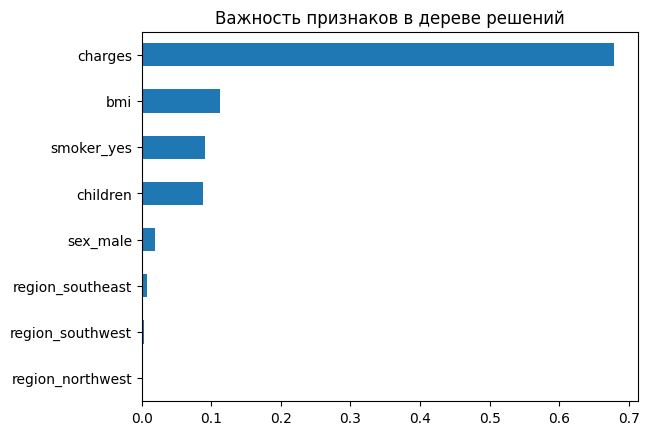

In [36]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Важность признаков в дереве решений')
plt.show()


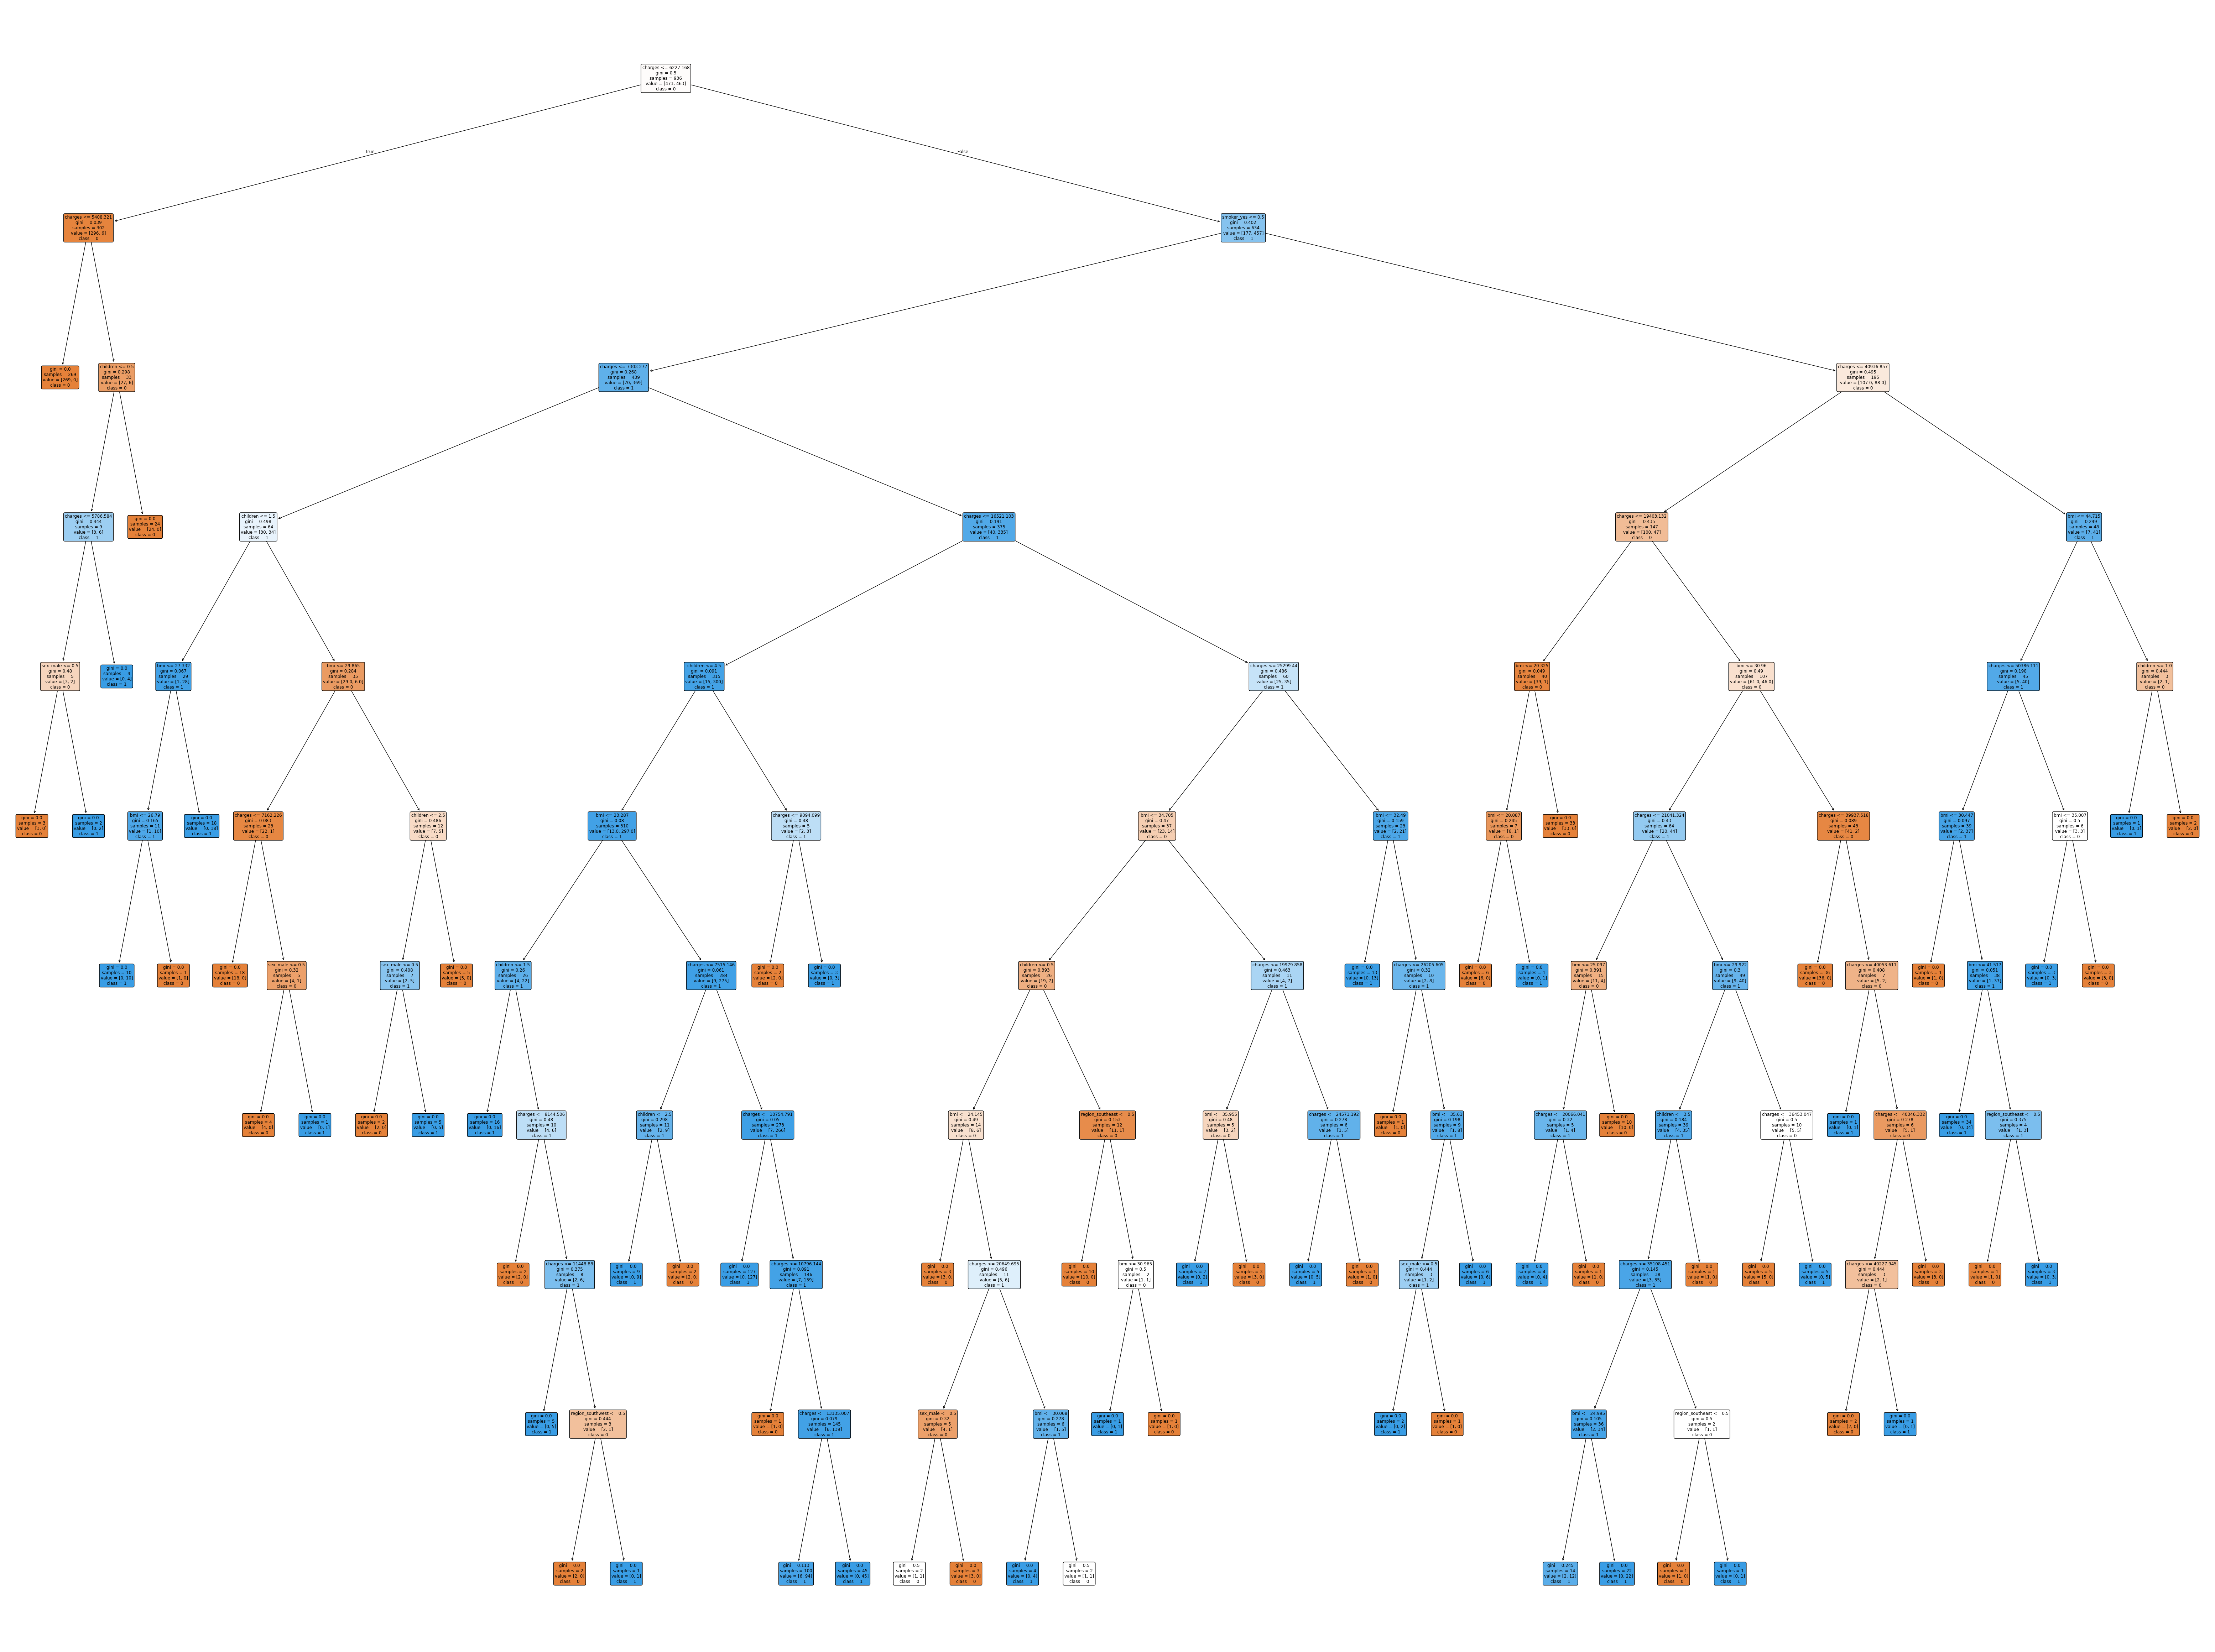

In [37]:
from sklearn.tree import plot_tree
# Визуализируем дерево решений
plt.figure(figsize=(80, 60))
plot_tree(tree_model, feature_names=X.columns, class_names=[str(item) for item in sorted(y.unique())], filled=True, rounded=True)
plt.show()


⏰ Домашнее задание
  1. Выбрать пременную для задачи бинарной классификации (назовем это x_binary, y_binary) и выбрать пременные для задачи мультиклассовой классификации (назовем это x_multi, y_multi)
p.s. если использовали произвольную пременную для binary, multiclassification - не зывбаем выбрасывать из X изначальную переменную

  - 2. Решить задачу классификации с использованием кросс валидации, оценить метрики качства: accuracy, precision, recall (включая classification report).
 - 2.1 Используя опыт прошлых работ, попробуйте использовать лучшие признаки для решения задачи
- 3. Для обоих задач побороться с дисбалансом классов следующими техниками:
oversampling (например, SMOTE)
или undersampling.
Для oversampling и undersampling используйте (https://imbalanced-learn.org/) Опишите полученный результат

Самый простой пример (желательно не использовать рандом)

In [38]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

- 4. Обучить дерево принятия решений с использованием кросс-валидации (Stratify K-fold и/или StratifyRandomShuffle)  для ```oversampling``` и ```undersampling``` (в задачи мультиклассовой классификации), оценить метрики и описать результат.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('insurance.csv')

#df['is_overprice'] = np.where(df['Price'] >= 10000, 1, 0)

old = np.zeros(len(df['age']), dtype=np.uint8)
for i in range(len(old)):
    if df['age'][i] < 25:
      old[i] = 1
    elif df['age'][i] < 40:
     old[i] = 2
    elif df['age'][i] < 55:
      old[i] = 3
    else:
      old[i] = 4

df['old'] = old

df.old = df.old.astype('category')
df.sex= df.sex.astype('category')
df.smoker= df.smoker.astype('category')
df.region=df.region.astype('category')

y = df['old'] # выбираем целевую переменную (категориальную)
X = df.drop('old', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('age', axis=1)
df.drop('age', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   sex       1338 non-null   category
 1   bmi       1338 non-null   float64 
 2   children  1338 non-null   int64   
 3   smoker    1338 non-null   category
 4   region    1338 non-null   category
 5   charges   1338 non-null   float64 
 6   old       1338 non-null   category
dtypes: category(4), float64(2), int64(1)
memory usage: 37.3 KB


In [40]:
X

,sex,bmi,children,smoker,region,charges
0,female,27.900,0,yes,southwest,16884.92400
1,male,33.770,1,no,southeast,1725.55230
2,male,33.000,3,no,southeast,4449.46200
3,male,22.705,0,no,northwest,21984.47061
4,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...
1333,male,30.970,3,no,northwest,10600.54830
1334,female,31.920,0,no,northeast,2205.98080
1335,female,36.850,0,no,southeast,1629.83350
1336,female,25.800,0,no,southwest,2007.94500


In [41]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns, drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.

In [43]:
y.value_counts()

,count
old,
3,422
2,396
1,278
4,242


In [44]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

# Инициализируем модель логистической регрессии
base_model = DecisionTreeClassifier(random_state=42, max_depth=5)

sfs = SequentialFeatureSelector(base_model, n_features_to_select=5)
sfs.fit(X, y)

# Получаем список отобранных признаков
selected_features_sfs = X.columns[sfs.get_support()]
print("Отобранные признаки SFS:", selected_features_sfs)

# Отбираем признаки
X_sfs = X[selected_features_sfs]

Отобранные признаки SFS: Index(['children', 'charges', 'sex_male', 'smoker_yes', 'region_northwest'], dtype='object')


In [45]:
from sklearn.tree import DecisionTreeClassifier
# Разделяем данные
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_sfs, y, test_size=0.3, random_state=42)

# Обучаем модель
tree_model = DecisionTreeClassifier(random_state=42, max_depth=5)
tree_model.fit(X_train_multi, y_train_multi)

# Предсказания
y_pred_multi = tree_model.predict(X_test_multi)

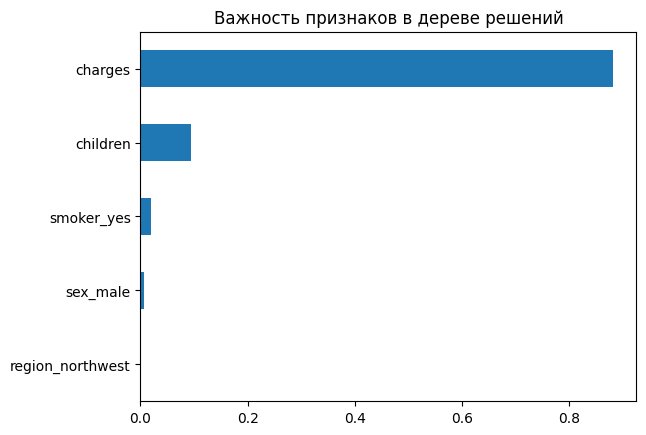

In [46]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(tree_model.feature_importances_, index=X_sfs.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Важность признаков в дереве решений')
plt.show()

In [47]:
# Применяем oversampling методом SMOTE
from imblearn.over_sampling import SMOTE
X_over, y_over = SMOTE().fit_resample(X_sfs, y)

y_over.value_counts()

,count
old,
1,422
2,422
3,422
4,422


In [48]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours

renn = RepeatedEditedNearestNeighbours()

X_under, y_under = renn.fit_resample(X_sfs, y)
y_under.value_counts()

,count
old,
4,242
3,217
2,161
1,153


In [49]:
# Импорт необходимых библиотек
import numpy as np
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, cross_val_score
from sklearn.metrics import classification_report

In [50]:
# K-Fold Cross-Validation
def k_fold_cross_validation(X, y, n_splits=3):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    # Реализация K-Fold вручную
    for train_index, test_index in kf.split(X):
        model = DecisionTreeClassifier(random_state=42, max_depth=5)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Выводим среднюю точность и точности по каждому фолду
    print(f"K-Fold Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому фолду: {accuracies}")

In [51]:
# Без балансировки:
k_fold_cross_validation(X = X_sfs.to_numpy(), y = y.to_numpy())


Classification Report:
               precision    recall  f1-score   support

           1       0.73      0.82      0.77        82
           2       0.85      0.64      0.73       143
           3       0.69      0.79      0.74       146
           4       0.74      0.77      0.76        75

    accuracy                           0.75       446
   macro avg       0.75      0.76      0.75       446
weighted avg       0.76      0.75      0.75       446


Classification Report:
               precision    recall  f1-score   support

           1       0.85      0.64      0.73        90
           2       0.78      0.72      0.75       131
           3       0.60      0.84      0.70       139
           4       0.81      0.58      0.68        86

    accuracy                           0.72       446
   macro avg       0.76      0.70      0.71       446
weighted avg       0.74      0.72      0.72       446


Classification Report:
               precision    recall  f1-score   support



In [52]:
# Oversampling:
k_fold_cross_validation(X = X_over.to_numpy(), y = y_over.to_numpy())


Classification Report:
               precision    recall  f1-score   support

           1       0.83      0.79      0.81       149
           2       0.88      0.66      0.76       142
           3       0.68      0.85      0.76       144
           4       0.82      0.85      0.84       128

    accuracy                           0.79       563
   macro avg       0.80      0.79      0.79       563
weighted avg       0.80      0.79      0.79       563


Classification Report:
               precision    recall  f1-score   support

           1       0.97      0.59      0.73       121
           2       0.83      0.66      0.73       146
           3       0.50      0.81      0.62       150
           4       0.81      0.74      0.77       146

    accuracy                           0.70       563
   macro avg       0.78      0.70      0.71       563
weighted avg       0.77      0.70      0.71       563


Classification Report:
               precision    recall  f1-score   support



Там, где было много, оверсамплинг сделал хуже там, где не хватало, он приравнял точность, что может считаться за нормальный результат(наверное)

In [53]:
# Undersampling:
k_fold_cross_validation(X = X_under.to_numpy(), y = y_under.to_numpy())


Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.96      0.98        57
           2       0.98      1.00      0.99        50
           3       0.99      0.92      0.95        73
           4       0.92      0.99      0.95        78

    accuracy                           0.97       258
   macro avg       0.97      0.97      0.97       258
weighted avg       0.97      0.97      0.97       258


Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.98      0.99        48
           2       1.00      0.97      0.98        59
           3       0.99      0.93      0.96        73
           4       0.92      1.00      0.96        78

    accuracy                           0.97       258
   macro avg       0.98      0.97      0.97       258
weighted avg       0.97      0.97      0.97       258


Classification Report:
               precision    recall  f1-score   support



Undersampling очень сильно повысил точность

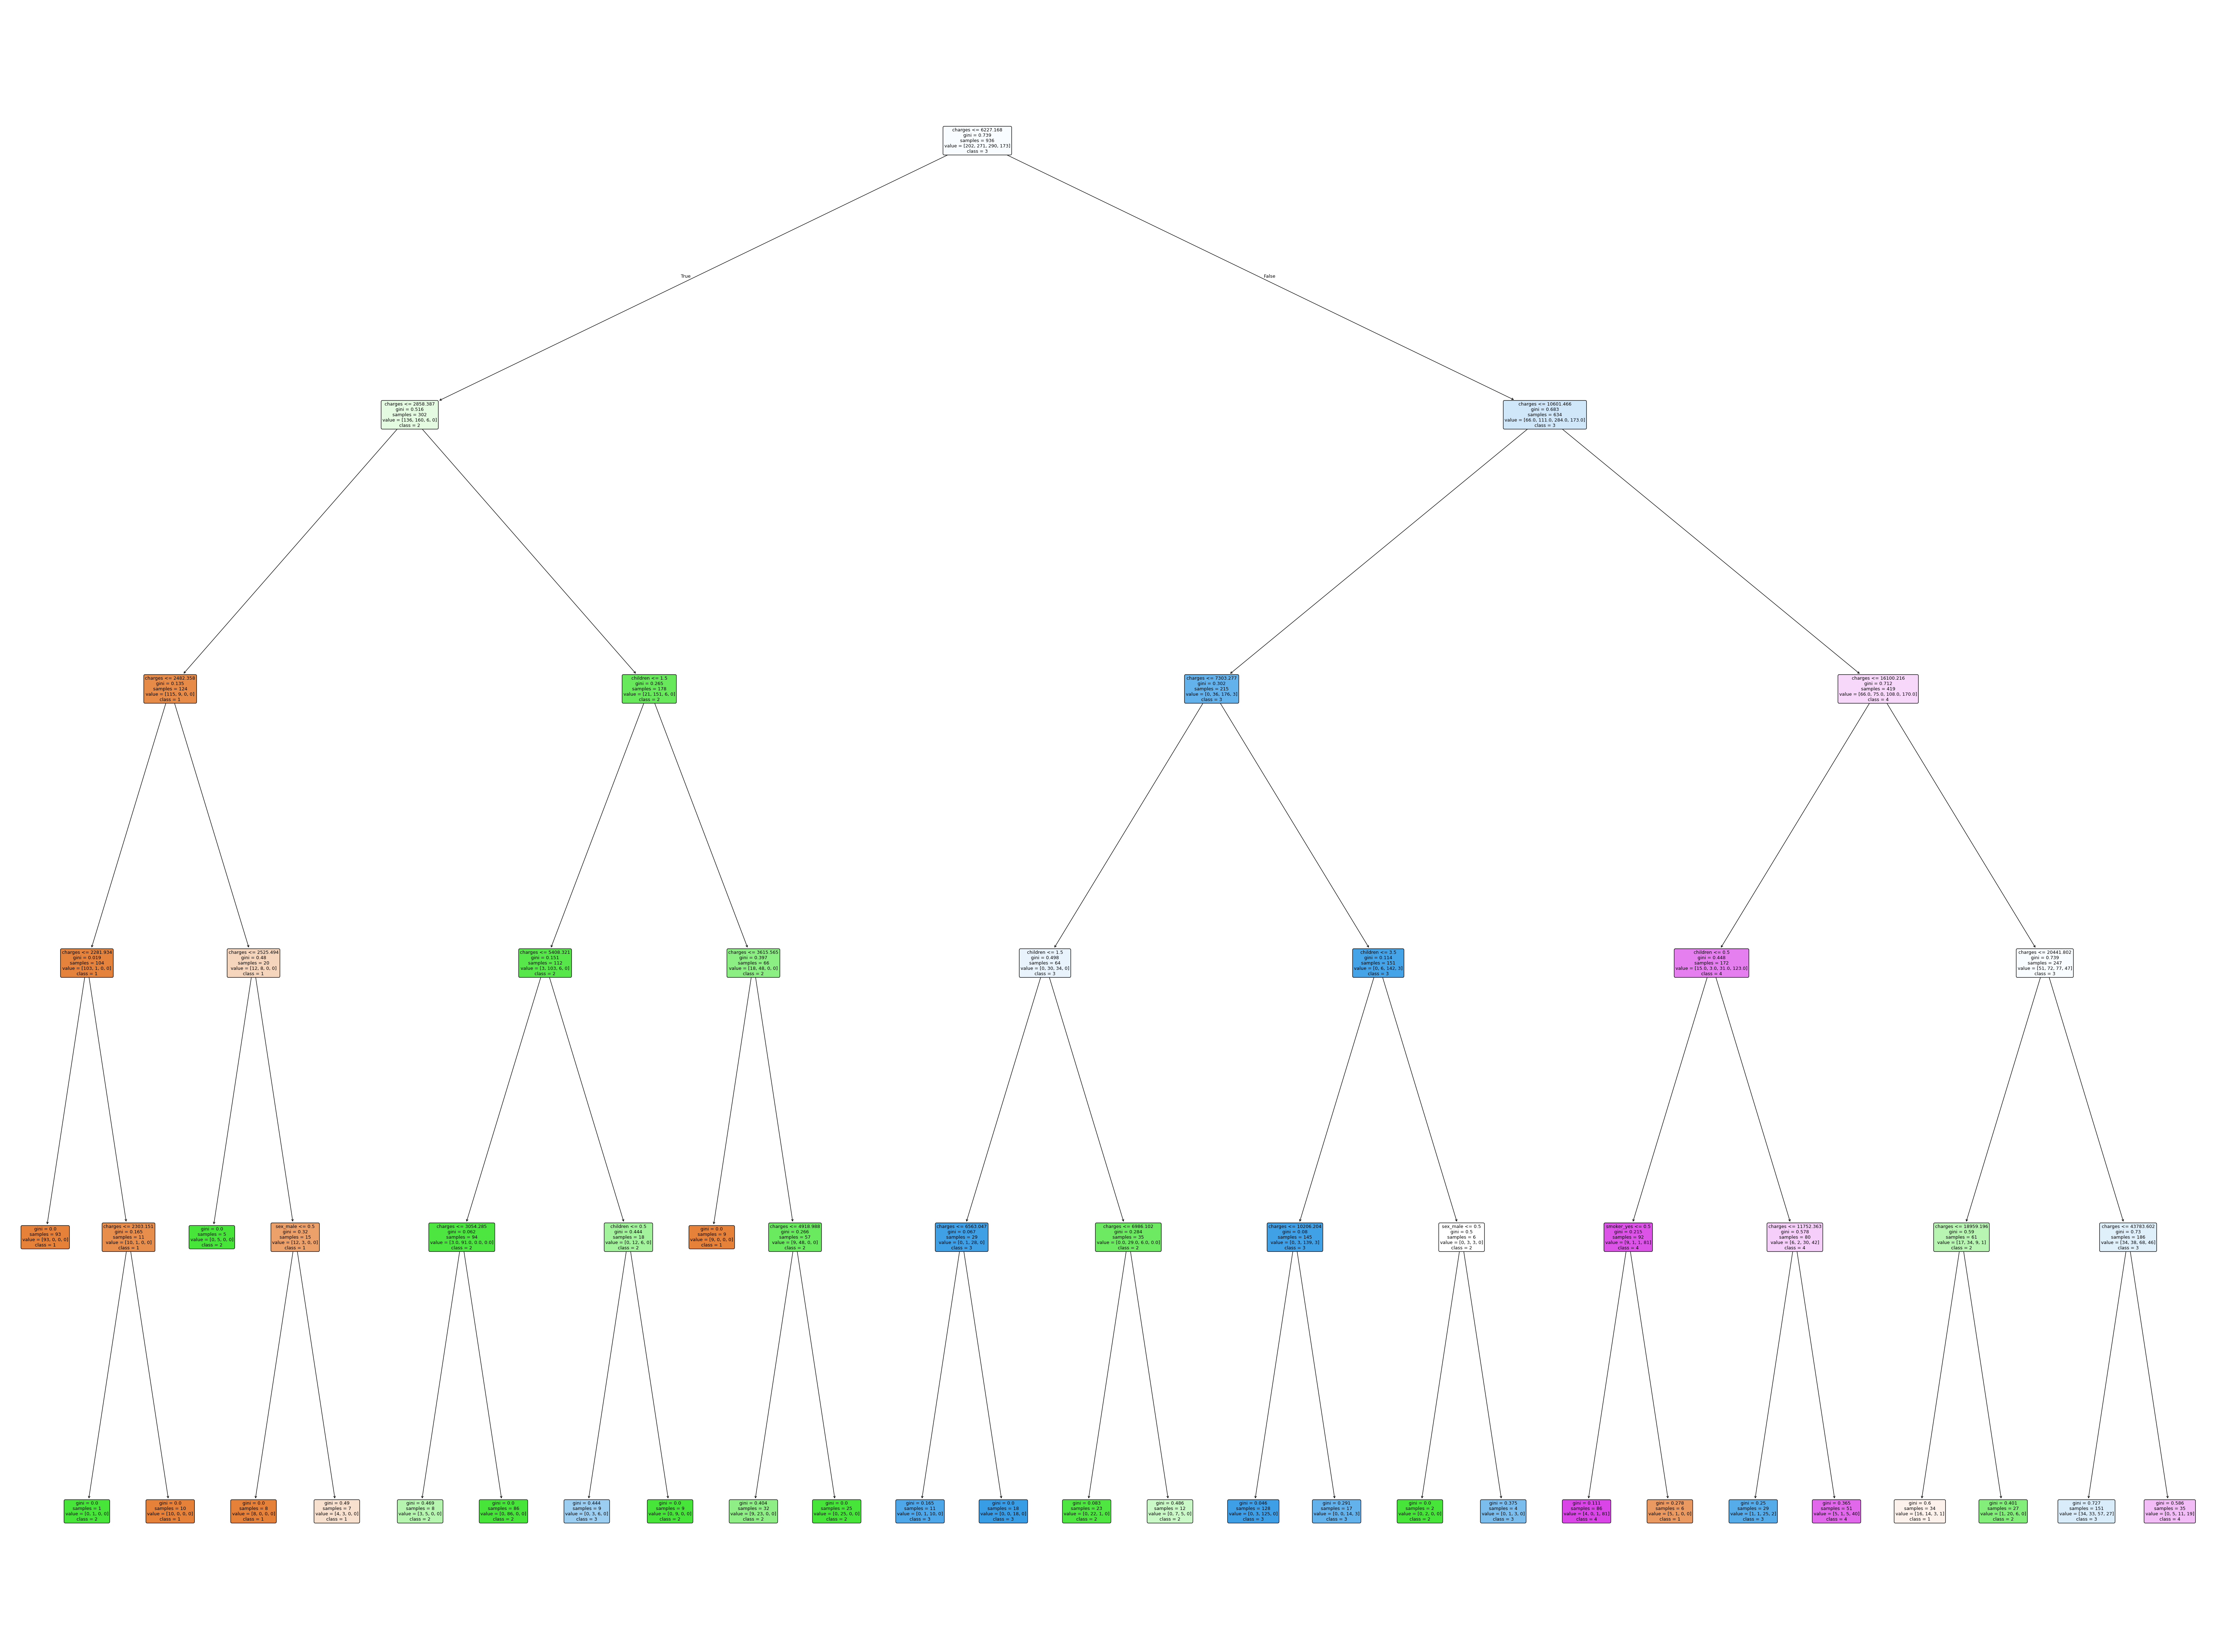

In [54]:
from sklearn.tree import plot_tree
# Визуализируем дерево решений
plt.figure(figsize=(80, 60))
plot_tree(tree_model, feature_names=X_sfs.columns, class_names=[str(item) for item in sorted(y.unique())], filled=True, rounded=True)
plt.show()